In [108]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

In [72]:
tf.random.set_seed(1)

In [73]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [74]:
x_train = x_train.reshape(-1, 28*28) / 255
x_test = x_test.reshape(-1, 28*28) / 255

In [75]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [76]:
model = keras.Sequential([
    layers.Input(shape=(784,)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [77]:
def myloss(y_true, y_pred):
    return tf.reduce_mean(y_true - y_pred)

In [78]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss= myloss,  # keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
              )

In [79]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 8.0963e-11 - categorical_accuracy: 0.0754
Epoch 2/3
1875/1875 [==============================] - 3s 1ms/step - loss: -8.5980e-11 - categorical_accuracy: 0.0801
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: -9.1642e-12 - categorical_accuracy: 0.0825


In [80]:
class MyLoss(keras.losses.Loss):
    def __init__(self, alpha=1.0, beta=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta

    def call(self, y_true, y_pred):
        return tf.reduce_mean(tf.square(self.alpha * y_true - self.beta * y_pred))

In [81]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=MyLoss(0.2, 0.1),
              metrics=['Accuracy'])

In [82]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0016 - Accuracy: 0.8504
Epoch 2/3
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0016 - Accuracy: 0.8419
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0016 - Accuracy: 0.8388


In [83]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name='my_metric'):
        super().__init__(name=name)
        self.true_positives = self.add_weight(name='acc', initializer='zeros')
        self.count = tf.Variable(0.0)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        y_true = tf.reshape(tf.argmax(y_true, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, 'int32') == tf.cast(y_pred, 'int32')

        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)

        values = tf.cast(values, 'float32')

        self.true_positives.assign_add(tf.reduce_mean(values))
        self.count.assign_add(1.0)

    def result(self):
        return self.true_positives / self.count

    def reset_state(self):
        self.true_positives.assign(0.0)
        self.count.assign(0.0)

In [84]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=MyLoss(0.5, 2.0),
              metrics=[keras.metrics.CategoricalAccuracy(), CategoricalTruePositives()])

In [85]:
model.fit(x_train, y_train, epochs=3)

Epoch 1/3
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2916 - categorical_accuracy: 0.6650 - my_metric: 0.6650
Epoch 2/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3556 - categorical_accuracy: 0.3464 - my_metric: 0.3464
Epoch 3/3
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3886 - categorical_accuracy: 0.1820 - my_metric: 0.1820


In [86]:
# auto encoder

In [87]:
enc_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu')(enc_input)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2, padding='same')(x)
x = layers.Flatten()(x)
hidden_output = layers.Dense(8, activation='linear')(x)

In [88]:
x = layers.Dense(7 * 7 * 8, activation='relu')(hidden_output)
x = layers.Reshape((7, 7, 8))(x)
x = layers.Conv2DTranspose(64, 5, strides=(2, 2), activation='relu', padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2DTranspose(32, 5, strides=(2, 2), activation='linear', padding='same')(x)
x = layers.BatchNormalization()(x)
dec_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same', name='dec_output')(x)

In [89]:
x2 = layers.Dense(128, activation='relu')(hidden_output)
class_output = layers.Dense(10, activation='softmax', name='class_output')(x2)

In [90]:
model = keras.Model(enc_input, [dec_output, class_output])

In [91]:
# variant 1
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[keras.metrics.CategoricalAccuracy()])

In [92]:
(x_train, _), (x_test, _) = mnist.load_data()

In [93]:
x_train = x_train / 255
x_test = x_test / 255

In [94]:
model.fit(x_train, [x_train, y_train], epochs=1)

1875/1875 [==============================] - 72s 38ms/step - loss: 0.2155 - dec_output_loss: 0.0460 - class_output_loss: 0.1696 - dec_output_categorical_accuracy: 0.2246 - class_output_categorical_accuracy: 0.9483


In [97]:
# Variant 2
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss={
                  'dec_output': 'mean_squared_error',
                  'class_output': 'categorical_crossentropy'
              },
              metrics={
                  'dec_output': None,
                  'class_output': 'acc'
              })

In [98]:
(x_train, _), (x_test, _) = mnist.load_data()

In [99]:
x_train = x_train / 255
x_test = x_test / 255

In [100]:
model.fit(x_train, [x_train, y_train], epochs=1)

1875/1875 [==============================] - 74s 39ms/step - loss: 0.1465 - dec_output_loss: 0.0413 - class_output_loss: 0.1052 - class_output_acc: 0.9715


In [117]:
# Variant 2 with loss_weight
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01),
              loss={
                  'dec_output': 'mean_squared_error',
                  'class_output': 'categorical_crossentropy'
              },
              loss_weights=(1.0, 0.7),
              metrics={
                  'dec_output': None,
                  'class_output': 'acc'
              })

In [118]:
(x_train, _), (x_test, _) = mnist.load_data()

In [119]:
x_train = x_train / 255
x_test = x_test / 255

In [120]:
model.fit(x_train, {'dec_output': x_train, 'class_output': y_train}, epochs=1)

1875/1875 [==============================] - 70s 37ms/step - loss: 0.1110 - dec_output_loss: 0.0392 - class_output_loss: 0.1026 - class_output_acc: 0.9723


In [121]:
p = model.predict(tf.expand_dims(x_test[0], axis=0))

1/1 [==============================] - 0s 143ms/step


In [122]:
print(tf.argmax(p[1], axis=1).numpy())

[7]


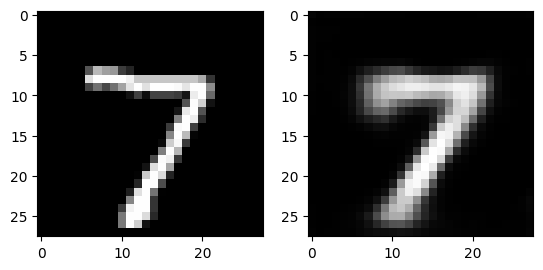

In [123]:
plt.subplot(121)
plt.imshow(x_test[0], cmap='gray')
plt.subplot(122)
plt.imshow(p[0].squeeze(), cmap='gray')
plt.show()